- 협업필터링 개념
- 협업필터링 종류: 모델기반, 이웃기반, 하이브리드, 딥러닝기반 ... 
- 이웃기반 협업필터링 유사도계산, 아이템기반, 유저기반 -> 유사도; 자카드, 피어슨, 코사인 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## Dataset 불러오기
- ratings.csv를 train/test로 나눈다

In [ ]:
# 각자 작업 환경에 맞는 경로를 지정해주세요. Google Colab과 Jupyter환경에서 경로가 다를 수 있습니다.
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


## Sparse Matrix 만들기
- `train_df`의 sparse matrix를 만드는 과정(2가지)

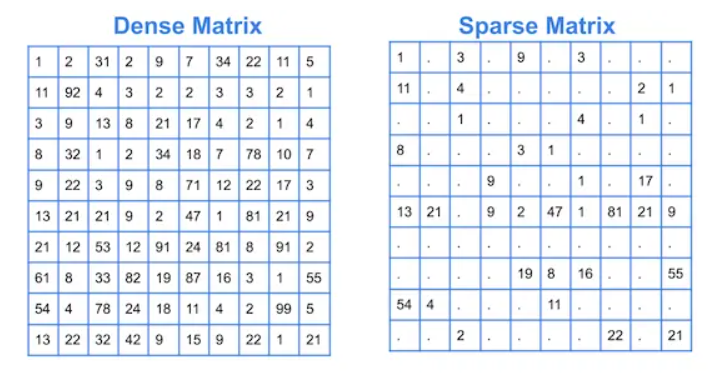

[출처] : https://cmdlinetips.com/2018/03/sparse-matrices-in-python-with-scipy/


- sparse matrix = 
(user, movie)

### 1. 연산량이 많아서 시간이 오래걸리는 방법

In [ ]:
user_ids = sorted(list(set(train_df['userId'].values)))
movie_ids = sorted(list(set(train_df['movieId'].values)))

print(f'유저 수: {len(user_ids)}, 영화 수: {len(movie_ids)}')
print(user_ids)
print(movie_ids)

유저 수: 610, 영화 수: 8938
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 

In [ ]:
# Empty sparse matrix를 dataframe 형태로 준비
sparse_matrix = pd.DataFrame(index=movie_ids, columns=user_ids)
sparse_matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# train_df의 movieId를 기준으로 groupBy
grouped = train_df.groupby('movieId')
grouped['userId'].count()

movieId
1         169
2          82
3          44
4           4
5          38
         ... 
193573      1
193579      1
193581      1
193587      1
193609      1
Name: userId, Length: 8938, dtype: int64

In [ ]:
idx = 0
for movieId, group in grouped:
  if idx < 1:
    print(group)
    group_copied = group.transpose()
    group_copied.loc['userId'] = pd.to_numeric(group_copied.loc['userId'])
    print(group_copied)
    group_copied.columns = group_copied.loc['userId']
    print(group_copied)
    group_copied = group_copied.drop(['userId', 'movieId']).rename(index={'rating': movieId})
    print(group_copied)
    print(group_copied.columns)
    print(group_copied.index)
  else:
    continue
  idx += 1

In [ ]:
for movieId, group in tqdm(grouped):
    group_copied = group
    group_copied = group_copied.transpose()
    group_copied.loc['userId'] = pd.to_numeric(group_copied.loc['userId'])
    group_copied.columns = group_copied.loc['userId']
    group_copied = group_copied.drop(['userId', 'movieId']).rename(index={'rating': movieId})

    sparse_matrix.update(group_copied)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: ignored

### 2. 간단하고 효율적인 방법
- pandas dataframe의 unstack(계층적 인덱싱)

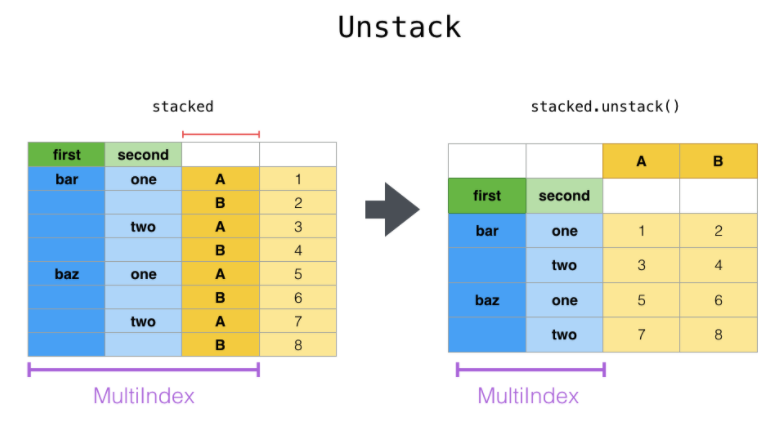

- [참고 링크 1](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html)
- [참고 링크 2](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)

In [ ]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,4.0,NaN,4.0,3.0,4.0,2.5,NaN,2.5,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,2.5,4.0,NaN,4.0,NaN,NaN,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- `MEMO`: 0이 아닌 다른 숫자를 주는 것도 또 하나 시도해 볼 수 있는 실험이다. 


## 코사인 유사도 활용하기

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def cossim_matrix(a, b):
    cossim_values = cosine_similarity(a.values, b.values)
    cossim_df = pd.DataFrame(data=cossim_values, columns = a.index.values, index=a.index)

    return cossim_df

## Neighborhood-based 협업필터링 추천점수 계산하기

### Item-based

In [ ]:
item_sparse_matrix = sparse_matrix.fillna(0)
item_sparse_matrix.shape

(8938, 610)

In [ ]:
item_cossim_df = cossim_matrix(item_sparse_matrix, item_sparse_matrix)
item_cossim_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.304336,0.267816,0.040259,0.221228,0.266544,0.149392,0.132943,0.182044,0.296838,0.257709,0.139632,0.113701,0.164856,0.103301,0.242000,0.246986,0.101015,0.251669,0.131482,0.261433,0.182307,0.164879,0.222668,0.266991,0.140973,0.108473,0.109745,0.181797,0.053777,0.162647,0.422169,0.402208,0.266803,0.116007,0.297235,0.0,0.085053,0.021893,0.114641,...,0.000000,0.057923,0.045449,0.028962,0.090051,0.077231,0.077231,0.077231,0.077231,0.045207,0.0,0.05933,0.040932,0.0,0.060720,0.082251,0.028962,0.028962,0.061785,0.000000,0.077231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.304336,1.000000,0.226138,0.052482,0.154783,0.209716,0.189420,0.068012,0.027945,0.303157,0.244600,0.156918,0.073411,0.083439,0.158038,0.205833,0.146949,0.193136,0.458342,0.092049,0.235169,0.142401,0.052102,0.182855,0.057490,0.139123,0.037172,0.115826,0.189215,0.000000,0.152457,0.258012,0.324845,0.147365,0.119390,0.336617,0.0,0.078364,0.029729,0.092547,...,0.000000,0.000000,0.165209,0.000000,0.050024,0.000000,0.000000,0.000000,0.000000,0.156683,0.0,0.00000,0.000000,0.0,0.069710,0.136606,0.000000,0.000000,0.000000,0.110117,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.267816,0.226138,1.000000,0.000000,0.306435,0.245555,0.368724,0.168267,0.253679,0.178219,0.235708,0.122641,0.149451,0.138664,0.052048,0.236722,0.188948,0.203784,0.244938,0.073150,0.229087,0.223028,0.115734,0.247492,0.198245,0.127082,0.238175,0.114782,0.110742,0.000000,0.198132,0.233039,0.151203,0.239877,0.119628,0.191147,0.0,0.123729,0.103266,0.208362,...,0.000000,0.000000,0.000000,0.000000,0.089110,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.096418,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.040259,0.052482,0.000000,1.000000,0.095673,0.068708,0.205962,0.000000,0.000000,0.044835,0.144579,0.000000,0.000000,0.161852,0.000000,0.000000,0.125440,0.000000,0.025580,0.000000,0.155352,0.069693,0.000000,0.000000,0.185360,0.051463,0.000000,0.000000,0.000000,0.000000,0.187215,0.050263,0.064871,0.112260,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.221228,0.154783,0.306435,0.095673,1.000000,0.238683,0.343507,0.204088,0.222925,0.150729,0.215188,0.198332,0.110459,0.153343,0.000000,0.156847,0.226190,0.128029,0.194406,0.046290,0.125510,0.176078,0.117994,0.246658,0.267305,0.089126,0.260605,0.049500,0.163221,0.000000,0.275988,0.222996,0.181409,0.198536,0.169278,0.182216,0.0,0.083955,0.000000,0.240221,...,0.178434,0.000000,0.000000,0.000000,0.054040,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.058472,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [ ]:
# movieId: 8938개, userId: 610개
# train_df에 포함된 userId를 계산에 반영한다
userId_grouped = train_df.groupby('userId')
# index: userId, columns: total movieId
item_prediction_result_df = pd.DataFrame(index=list(userId_grouped.indices.keys()), columns=item_sparse_matrix.index)
item_prediction_result_df

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for userId, group in tqdm(userId_grouped):
    # user가 rating한 movieId * 전체 movieId
    user_sim = item_cossim_df.loc[group['movieId']]
    # user가 rating한 movieId * 1
    user_rating = group['rating']
    # 전체 movieId * 1
    sim_sum = user_sim.sum(axis=0)

    # userId의 전체 rating predictions (8938 * 1)
    pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating) / (sim_sum+1)
    item_prediction_result_df.loc[userId] = pred_ratings

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [ ]:
item_prediction_result_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,4.20279,4.18783,4.17609,3.03272,4.04561,4.24019,3.9933,3.90547,3.70279,4.18855,4.16638,3.96413,4.07492,3.89619,3.81881,4.2132,4.16727,4.13229,4.16556,4.1066,4.16574,4.086,4.14826,4.13404,4.13482,4.08018,3.71706,4.0126,4.19837,3.82467,4.09918,4.21487,4.21771,4.13656,4.03317,4.17642,0.863706,4.00858,4.03026,4.09802,...,2.81089,1.78243,3.99862,3.18195,4.07664,3.62958,3.62958,3.21241,3.62958,3.59316,3.74393,3.88679,3.12593,2.2081,3.96647,4.15315,3.18195,3.18195,3.24997,3.83627,3.62958,0.979003,0.979003,0,1.45119,2.40757,0.979003,0.979003,0.979003,0.979003,0.979003,0,0,0,0,0,0,0,0,1.38273
2,3.19261,3.15207,2.46138,0.280903,2.61916,2.9754,1.85877,1.68768,1.09268,3.02235,2.54129,2.51385,1.61082,0.758551,1.63399,3.18457,2.53038,2.90807,3.22072,2.92756,2.40354,2.14887,2.35921,2.71687,2.21494,2.23787,1.19091,1.83372,2.29285,0.196298,2.65615,3.05432,2.98765,2.38185,2.62798,2.91054,0,1.71507,1.77847,2.03524,...,2.61665,0,2.69157,1.20283,2.21043,1.95442,1.95442,1.91231,1.95442,2.76609,2.94477,2.44461,1.33566,1.90164,3.10808,2.94114,1.20283,1.20283,2.26655,2.28051,1.95442,0.387743,0.387743,1.70885,0.362692,1.91228,0.387743,0.387743,0.387743,0.387743,0.387743,1.70885,1.70885,1.70885,1.70885,1.70885,1.70885,1.70885,1.70885,2.32666
3,1.32315,1.20446,1.39635,0.217016,0.819716,1.59889,0.802514,0.755008,0.86708,1.55365,0.942893,1.34004,0.620453,0.450938,0.886356,1.34587,0.85248,1.39133,1.26625,0.999873,1.08345,1.13544,0.846797,1.04494,0.862301,0.817965,0.377594,0.406655,1.5742,1.38647,1.15163,1.46737,1.11338,0.947678,1.03943,1.18457,0,0.873352,0.950293,0.834913,...,0.0383185,0.224785,1.08515,0,0.807464,0.715827,0.715827,0.458293,0.715827,0.55052,0.314237,0.822655,0.469606,0.034753,0.784118,1.03524,0,0,0.397776,0.619607,0.715827,0,0,0,0.213525,0.115378,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.48994,3.48805,3.38864,3.15017,3.30488,3.50267,3.31794,2.90629,3.03413,3.41697,3.42383,3.2559,3.18772,3.38452,3.20826,3.46465,3.51254,3.44664,3.41673,3.30509,3.5149,3.26365,3.33294,3.42041,3.46056,3.48881,3.06763,3.43736,3.58361,3.47541,3.26032,3.47623,3.49028,3.51451,3.43002,3.46574,0.492723,3.33497,3.31457,3.4271,...,2.43625,1.63485,3.11562,3.34077,3.24972,2.96916,2.96916,2.62972,2.96916,2.7532,3.08765,3.18312,2.56696,1.22959,3.22873,3.32863,3.34077,3.34077,2.62846,3.23077,2.96916,1.0335,1.0335,0.505535,0.810046,1.89312,1.0335,1.0335,1.0335,1.0335,1.0335,0.505535,0.505535,0.505535,0.505535,0.505535,0.505535,0.505535,0.505535,1.963
5,3.27916,3.1278,2.99947,2.56582,2.94179,3.16869,3.00793,2.67809,2.27668,3.01557,3.12409,2.23444,2.59869,3.02734,2.68661,3.08962,3.16745,2.82838,3.00623,2.50037,3.22707,2.88812,2.82624,2.87902,3.15316,2.91281,2.45999,2.90752,3.05304,2.43656,2.9588,3.18185,3.22697,3.31433,2.28735,3.17345,0.158787,2.73675,2.10767,2.91458,...,0.854196,0.33135,2.04168,1.80091,2.33965,1.83931,1.83931,1.53293,1.83931,1.65368,1.70121,2.0751,1.23932,0.318296,2.13799,2.66672,1.80091,1.80091,1.52717,1.83851,1.83931,0.391638,0.391638,0,0.460137,0.680643,0.391638,0.391638,0.391638,0.391638,0.391638,0,0,0,0,0,0,0,0,0.562705
6,3.58597,3.57233,3.53615,3.33866,3.51444,3.5477,3.53826,3.42057,3.3406,3.55275,3.57423,3.32095,3.4276,3.48652,3.50615,3.52936,3.53836,3.42938,3.523,3.3589,3.54642,3.50513,3.49329,3.4643,3.5083,3.50719,3.46573,3.52401,3.40919,2.98586,3.50899,3.54346,3.6113,3.5479,3.39448,3.59635,0.343524,3.44129,3.23668,3.44547,...,2.32125,1.06784,3.10313,1.82397,3.22679,2.24826,2.24826,1.7323,2.24826,2.48076,2.90869,2.71012,1.81119,0.883528,3.08411,3.29296,1.82397,1.82397,1.82883,2.57412,2.24826,0.446497,0.446497,0,0.289115,1.14777,0.446497,0.446497,0.446497,0.446497,0

In [ ]:
### 한줄씩 결과를 출력해서 확인하고 싶을 때 참고하세요.
# idx = 0
# for userId, group in grouped:
#   if idx < 1:
#     print(userId)
#     # user가 rating한 movieId * 전체 movieId
#     user_sim = cossim_df.loc[group['movieId']] # (n, 8938)
#     # user가 rating한 movieId * 1
#     user_rating = group['rating'] # (n, 1)
#     # 전체 movieId * 1
#     sim_sum = user_sim.sum(axis=0) # (8938, 1)

#     # userId의 전체 rating predictions 
#     pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating) / (sim_sum+1) # (8938 * 1)
#     prediction_result_df.loc[userId] = pred_ratings
#   idx += 1

### User-based

In [ ]:
user_sparse_matrix = sparse_matrix.fillna(0).transpose()

In [ ]:
user_sparse_matrix.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_sparse_matrix.shape

(610, 8938)

In [ ]:
user_cossim_df = cossim_matrix(user_sparse_matrix, user_sparse_matrix)
user_cossim_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.016665,0.070570,0.160438,0.075410,0.087404,0.123664,0.069225,0.037416,0.009900,0.116869,0.010900,0.097073,0.097351,0.160905,0.130733,0.233488,0.159436,0.229175,0.106378,0.134026,0.042174,0.080940,0.118462,0.057098,0.074305,0.176682,0.154508,0.115075,0.095219,0.116415,0.096891,0.116097,0.060039,0.018472,0.033715,0.080014,0.103986,0.265307,0.062876,...,0.068639,0.092376,0.193911,0.059231,0.038337,0.027807,0.259536,0.000000,0.127610,0.196391,0.032494,0.060829,0.041263,0.061662,0.118403,0.065398,0.079916,0.152958,0.049672,0.254597,0.084700,0.103389,0.142405,0.099736,0.068952,0.104889,0.232882,0.014377,0.226264,0.208385,0.056163,0.124896,0.162324,0.050852,0.101583,0.128198,0.240652,0.225897,0.063984,0.095228
2,0.016665,1.000000,0.000000,0.004295,0.020560,0.030996,0.027726,0.000000,0.000000,0.057112,0.050529,0.000000,0.000000,0.019706,0.094221,0.042154,0.080419,0.157239,0.014791,0.016695,0.076210,0.079124,0.000000,0.111357,0.181943,0.000000,0.000000,0.033860,0.096737,0.066817,0.000000,0.021255,0.038112,0.021178,0.000000,0.070899,0.034344,0.030872,0.000000,0.020290,...,0.000000,0.039103,0.124467,0.040580,0.000000,0.000000,0.000000,0.000000,0.000000,0.050032,0.130993,0.149300,0.000000,0.000000,0.094519,0.080066,0.000000,0.000000,0.032529,0.050973,0.042262,0.036289,0.053546,0.015933,0.000000,0.095991,0.014417,0.000000,0.079978,0.028680,0.151666,0.019379,0.006645,0.000000,0.000000,0.028180,0.000000,0.046286,0.033522,0.090288
3,0.070570,0.000000,1.000000,0.002677,0.000000,0.003477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017739,0.037489,0.003184,0.013792,0.015762,0.007023,0.003222,0.000488,0.003862,0.003162,0.000000,0.000000,0.002843,0.012381,0.007261,0.000000,0.004728,0.015895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002246,0.003035,...,0.009987,0.007018,0.000000,0.000000,0.000000,0.037043,0.003330,0.000000,0.000000,0.022490,0.005126,0.000000,0.000000,0.000000,0.000000,0.000000,0.005185,0.000000,0.000000,0.025883,0.000000,0.000000,0.003586,0.002482,0.000000,0.011629,0.019767,0.000000,0.030780,0.003817,0.002878,0.002174,0.027609,0.000000,0.000000,0.012090,0.000000,0.023927,0.000000,0.018332
4,0.160438,0.004295,0.002677,1.000000,0.121648,0.093634,0.106495,0.047930,0.000000,0.034281,0.051343,0.062434,0.068593,0.047313,0.056951,0.153868,0.115363,0.108863,0.173788,0.092159,0.035909,0.053011,0.069875,0.055751,0.021803,0.073772,0.100712,0.125315,0.062167,0.059498,0.075626,0.177156,0.134276,0.036773,0.050788,0.091729,0.072888,0.054797,0.169479,0.043322,...,0.011451,0.144048,0.102033,0.069941,0.009641,0.007079,0.129647,0.000000,0.063585,0.122387,0.047020,0.055886,0.058342,0.033610,0.095249,0.047437,0.105421,0.037728,0.051045,0.184120,0.105999,0.049010,0.209392,0.062336,0.082067,0.093637,0.210657,0.019309,0.160776,0.186949,0.065328,0.116656,0.251105,0.056396,0.075940,0.187236,0.102819,0.109515,0.038805,0.086941
5,0.075410,0.020560,0.000000,0.121648,1.000000,0.164390,0.075932,0.302418,0.000000,0.000000,0.118213,0.053365,0.000000,0.135476,0.083971,0.063830,0.096110,0.095612,0.079224,0.032121,0.041732,0.019271,0.052776,0.076803,0.052181,0.091675,0.102966,0.090528,0.028561,0.000000,0.017516,0.232930,0.204039,0.038300,0.296278,0.030812,0.214088,0.195768,0.106027,0.173635,...,0.000000,0.057779,0.068374,0.189874,0.000000,0.000000,0.088809,0.000000,0.159289,0.072059,0.075021,0.000000,0.061152,0.223592,0.000000,0.029744,0.127100,0.256836,0.096130,0.085791,0.000000,0.209454,0.146134,0.093192,0.085930,0.085811,0.068642,0.000000,0.054620,0.101157,0.090020,0.306634,0.103646,0.145354,0.119800,0.071333,0.064705,0.111755,0.159946,0.049236
...,..

In [ ]:
movieId_grouped = train_df.groupby('movieId')
user_prediction_result_df = pd.DataFrame(index=list(movieId_grouped.indices.keys()), columns=user_sparse_matrix.index)
user_prediction_result_df

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for movieId, group in tqdm(movieId_grouped):
    user_sim = user_cossim_df.loc[group['userId']]
    user_rating = group['rating']
    sim_sum = user_sim.sum(axis=0)

    pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating) / (sim_sum+1)
    user_prediction_result_df.loc[movieId] = pred_ratings

# return user_prediction_result_df.transpose()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [ ]:
print(item_prediction_result_df.shape)
print(user_prediction_result_df.transpose().shape)

(610, 8938)
(610, 8938)


In [ ]:
# 전체 user가 모든 movieId에 매긴 평점
print(item_prediction_result_df.head())
print(user_prediction_result_df.transpose().head())

user_prediction_result_df = user_prediction_result_df.transpose()

movieId   1        2        3       ...    193581    193587    193609
1        4.20279  4.18783  4.17609  ...         0         0   1.38273
2        3.19261  3.15207  2.46138  ...   1.70885   1.70885   2.32666
3        1.32315  1.20446  1.39635  ...         0         0         0
4        3.48994  3.48805  3.38864  ...  0.505535  0.505535     1.963
5        3.27916   3.1278  2.99947  ...         0         0  0.562705

[5 rows x 8938 columns]
         1        2        3       ...    193581    193587    193609
userId                             ...                              
1       3.67043  3.01898  3.02703  ...         0         0  0.140421
2       3.34895  2.57281   1.7197  ...  0.379994  0.332495  0.592074
3         2.121  1.27956  1.26626  ...         0         0         0
4       3.61963  2.93753  2.73966  ...  0.046584  0.040761  0.251308
5       3.76122  3.21044  2.92431  ...         0         0  0.142512

[5 rows x 8938 columns]


## RMSE로 추천시스템 성능 평가하기

In [ ]:
test_df.head()

,userId,movieId,rating,timestamp
99731,610,3527,5.0,1479545223
97583,606,1250,3.5,1171376891
38197,262,213,5.0,840310907
11474,68,69406,3.0,1261622505
34105,232,4728,3.0,1218166950


In [ ]:
def evaluate(test_df, prediction_result_df):
  groups_with_movie_ids = test_df.groupby(by='movieId')
  groups_with_user_ids = test_df.groupby(by='userId')
  intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
  intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

  print(len(intersection_movie_ids))
  print(len(intersection_user_ids))

  compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]
  # compressed_prediction_df

  # test_df에 대해서 RMSE 계산
  grouped = test_df.groupby(by='userId')
  result_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
      if userId in intersection_user_ids:
          pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
          pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
          actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})

          final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
          final_df = final_df.round(4) # 반올림

          # if not final_df.empty:
          #     rmse = sqrt(mean_squared_error(final_df['rating_actual'], final_df['rating_pred']))
          #     result_df.loc[userId] = rmse
          #     # print(userId, rmse)
    
  return final_df

In [ ]:
evaluate(test_df, user_prediction_result_df)

4385
610


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


,actual_rating,movieId,pred_rating
0,5.0,3527,3.28567
1,3.5,84772,2.21159
2,3.5,103141,2.83544
3,4.0,81132,0.450808
4,4.5,130634,1.02244
...,...,...,...
218,4.0,106100,2.86823
219,4.0,111759,3.51395
220,1.0,4852,0.202402
221,3.0,2628,2.93777


In [ ]:
evaluate(test_df, item_prediction_result_df)

4385
610


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


,actual_rating,movieId,pred_rating
0,5.0,3527,3.79741
1,3.5,84772,3.73065
2,3.5,103141,3.6897
3,4.0,81132,3.33402
4,4.5,130634,3.4512
...,...,...,...
218,4.0,106100,3.72969
219,4.0,111759,3.75842
220,1.0,4852,3.64888
221,3.0,2628,3.81238


In [ ]:
result_df = evaluate(test_df, user_prediction_result_df)
print(result_df)
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



     actual_rating  movieId pred_rating
0              5.0     3527     3.28567
1              3.5    84772     2.21159
2              3.5   103141     2.83544
3              4.0    81132    0.450808
4              4.5   130634     1.02244
..             ...      ...         ...
218            4.0   106100     2.86823
219            4.0   111759     3.51395
220            1.0     4852    0.202402
221            3.0     2628     2.93777
222            5.0     1953     3.17222

[223 rows x 3 columns]
RMSE: 1.6949489761800296


In [ ]:
result_df = evaluate(test_df, item_prediction_result_df)
print(result_df)
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



     actual_rating  movieId pred_rating
0              5.0     3527     3.79741
1              3.5    84772     3.73065
2              3.5   103141      3.6897
3              4.0    81132     3.33402
4              4.5   130634      3.4512
..             ...      ...         ...
218            4.0   106100     3.72969
219            4.0   111759     3.75842
220            1.0     4852     3.64888
221            3.0     2628     3.81238
222            5.0     1953     3.86646

[223 rows x 3 columns]
RMSE: 0.8145193961484049
